In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date, timedelta
import seaborn as sns
import numpy as np
import sys
sys.path.append("..")
from pygam import LinearGAM, f, s, te, l 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import copy 
import json
from utils.gam_result_utils import save_temp_effect_results, save_rain_effect_results

Prepare mstl data for GAM 

In [131]:
# data load 
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)

# mstl_data columns
print(mstl_data.columns.tolist())

['timestamp', 'city', 'counter_site', 'longitude', 'latitude', 'count', 'count_capped', 'log_count', 'trend', 'seasonal_24', 'seasonal_168', 'seasonal_8766', 'residual']


In [132]:
# extract the columns needed for GAMS
residual_data = mstl_data[['timestamp',
                           'city',
                           'counter_site',
                           'seasonal_8766',
                           'residual']].copy()

# remove rows containing the rownames
residual_data = residual_data[residual_data['timestamp']!='timestamp']

residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()
residual_data['year_plus_res'] = residual_data['residual'].astype(float).values + residual_data['seasonal_8766'].astype(float).values
residual_data.head(2)


,timestamp,city,counter_site,seasonal_8766,residual,id,year_plus_res
0,2012-12-31 23:00:00+00:00,Landeshauptstadt Stuttgart,König-Karls-Brücke Barometer,-1.8545503347710663,0.30620344321336024,5,-1.548347
1,2013-01-01 00:00:00+00:00,Landeshauptstadt Stuttgart,König-Karls-Brücke Barometer,-0.9312113949920525,0.7172102469645241,5,-0.214001


In [133]:
# reference timestamp (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist())) 
print(ref)

# 1) convert to datetime
t_0 = pd.to_datetime(residual_data['timestamp'], errors='coerce').dt.tz_convert('Europe/Berlin')

# 2) compute difference in hours 
residual_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0
# => timestamp_number is number of hours since reference timestamp 

# add columns weekday and hour of the day
residual_data['weekday'] = t_0.dt.dayofweek.astype(float).values            # 0–6
residual_data['hour'] = t_0.dt.hour.astype(float).values                    # 0–23

# assertion: values in weekday are in [0, 1, 2, 3, 4, 5, 6] 
assert set(residual_data['weekday']) == set(range(7))
# assertion: values in hour are in [0, 1, ..., 22, 23]
assert set(residual_data['hour']) == set(range(24))

2012-12-31 23:00:00+00:00


Prepare weather data for GAM

In [134]:
# load weather data 
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)
print(weather_data.head(2))
print(weather_data.isna().sum())
print(weather_data.columns.tolist())

                        date  temperature_2m  apparent_temperature  rain  \
0  2012-12-30 23:00:00+00:00          5.8285              1.619927   0.0   
1  2012-12-31 00:00:00+00:00          5.8285              1.688656   0.0   

   snowfall  forecast_temperature_2m  forecast_apparent_temperature  \
0       0.0                      NaN                            NaN   
1       0.0                      NaN                            NaN   

   forecast_rain  forecast_snowfall                        city  
0            NaN                NaN  Landeshauptstadt Stuttgart  
1            NaN                NaN  Landeshauptstadt Stuttgart  
date                                   0
temperature_2m                         0
apparent_temperature                   0
rain                                   0
snowfall                               0
forecast_temperature_2m          1586134
forecast_apparent_temperature    1586134
forecast_rain                    1586156
forecast_snowfall              

In [163]:
# Compute correlation between weather and forecast for rain and temperature

# Remove rows with NaN in the relevant columns
weather_complete = weather_data.dropna(subset=['temperature_2m', 'rain', 
                                                'forecast_temperature_2m', 'forecast_rain'])

# Calculate correlations
correlations = {
    'temperature': weather_complete['temperature_2m'].corr(weather_complete['forecast_temperature_2m']),
    'rain': weather_complete['rain'].corr(weather_complete['forecast_rain']),
}

print("\nCorrelations between observed weather and forecast:")
for var, corr in correlations.items():
    print(f"{var}: {corr:.4f}")


Correlations between observed weather and forecast:
temperature: 0.9826
rain: 0.3407


In [135]:
cities = residual_data['city'].unique()
print(cities)

['Landeshauptstadt Stuttgart' 'Stadt Freiburg' 'Stadt Heidelberg'
 'Stadt Ludwigsburg' 'Stadt Mannheim' 'Stadt Reutlingen' 'Stadt Tübingen']


In [136]:
def split_data(X_weather: pd.DataFrame, X_forecast: pd.DataFrame, y: pd.Series, site_col: str = "id", time_col: str = "timestamp_number", train_frac: float = 0.8,):
# split data into train- and test set based on id and time 
    
    train_idx = []
    test_idx = []

    for site, group in X_weather.groupby(site_col):
        group = group.sort_values(time_col)
        split = int(train_frac * len(group))

        train_idx.extend(group.index[:split])
        test_idx.extend(group.index[split:])
    
    # split DataFrames / Series
    X_weather_train = X_weather.loc[train_idx].copy()
    X_weather_test  = X_weather.loc[test_idx].copy()

    X_forecast_train = X_forecast.loc[train_idx].copy()
    X_forecast_test  = X_forecast.loc[test_idx].copy()

    y_train = y.loc[train_idx].copy()
    y_test  = y.loc[test_idx].copy()

    assert set(X_weather_train[site_col]) == set(X_weather_test[site_col])
    assert set(X_forecast_train[site_col]) == set(X_forecast_test[site_col])

    assert len(y_train) == len(X_weather_train) == len(X_forecast_train)
    assert len(y_test) == len(X_weather_test) == len(X_forecast_test)

    return X_weather_train, X_weather_test, X_forecast_train, X_forecast_test, y_train, y_test

In [ ]:
# Iterate over all cities
# compute for each city normalized weather data
# store city-specific data in a dictionary

prepared_data_dict = {}

for city in cities:

    city_data = residual_data[residual_data['city'] == city]
    w = weather_data[weather_data['city'] == city].copy()

    # merge with weather data by city and date (in weather data) and timestamp (in city_data)
    merged_data = pd.merge(city_data, w, left_on=['city', city_data['timestamp']], right_on=['city', w['date']], how='left')

    # define features and target variable
    feature_cols_weather = ['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall', 'weekday', 'hour'] 
    feature_cols_forecast = ['timestamp_number', 'id', 'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall', 'weekday', 'hour']
    X_weather = merged_data[feature_cols_weather].astype(float)
    X_forecast = merged_data[feature_cols_forecast].astype(float)
    y = merged_data['year_plus_res'] 


    # drop rows with NaN values in X or y
    valid_idx = (y.notna() &
                X_weather.notna().all(axis=1) &
                X_forecast.notna().all(axis=1)
                )
    X_weather = X_weather.loc[valid_idx].copy()
    X_forecast = X_forecast.loc[valid_idx].copy()
    y = y.loc[valid_idx].copy()


    X_weather_train, X_weather_test, X_forecast_train, X_forecast_test, y_train, y_test = split_data(X_weather, X_forecast, y)
    X_weather_normalized = X_weather.copy()
    X_forecast_normalized = X_forecast.copy()
    city_means_stds = []

    # Normalize weather data
    for col in ['temperature_2m', 'rain', 'snowfall']:
        mean = X_weather_train[col].mean()
        std = X_weather_train[col].std()
        city_means_stds.append((col, mean, std))

        X_weather_train[col] = (X_weather_train[col] - mean) / std
        X_weather_test[col]  = (X_weather_test[col] - mean) / std

        X_weather_normalized[col] = (X_weather_normalized[col] - mean) / std

    for col in ['forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall']:
        mean = X_forecast_train[col].mean()
        std = X_forecast_train[col].std()
        city_means_stds.append((col, mean, std))

        X_forecast_train[col] = (X_forecast_train[col] - mean) / std
        X_forecast_test[col]  = (X_forecast_test[col] - mean) / std

        X_forecast_normalized[col] = (X_forecast_normalized[col] - mean) / std


    feature_names_weather = X_weather_train.columns.tolist()
    feature_names_forecast = X_forecast_train.columns.tolist()

    # convert input data to numpy arrays
    X_weather_train = X_weather_train.values
    X_weather_test  = X_weather_test.values

    X_forecast_train = X_forecast_train.values
    X_forecast_test = X_forecast_test.values

    y_train = y_train.values
    y_test  = y_test.values

    prepared_data_dict[city] = {
        'X_weather_train': X_weather_train,
        'X_weather_test': X_weather_test,
        'X_forecast_train': X_forecast_train,
        'X_forecast_test': X_forecast_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_cols_weather': feature_names_weather,
        'feature_cols_forecast': feature_names_forecast, 
        'X_weather_normalized': X_weather_normalized,
        'X_forecast_normalized': X_forecast_normalized,
        'city_means_stds': city_means_stds
    }

    assert len(X_weather_train) == len(y_train)
    assert len(X_weather_test) == len(y_test)
    assert len(X_forecast_train) == len(y_train)
    assert len(X_forecast_test) == len(y_test)  
    assert len(X_weather_train) + len(X_weather_test) == len(X_weather_normalized)
    assert len(X_forecast_train) + len(X_forecast_test) == len(X_forecast_normalized)
    assert len(city_means_stds) == 6  # 3 weather + 3 forecast features, each with mean and std

In [138]:
print(prepared_data_dict['Stadt Tübingen']['feature_cols_weather'])

['timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall', 'weekday', 'hour']


In [139]:
print(prepared_data_dict['Stadt Tübingen']['X_weather_train'].shape)
print(prepared_data_dict['Stadt Tübingen']['X_weather_test'].shape)
print(X_weather_normalized.shape)

(67375, 7)
(16845, 7)
(84220, 7)


In [ ]:
metrics_dict = {}
city_models = {"observed": {}, "forecast": {}}

# Iterate over all cities
# train for each city a GAM on oberserved weather data, forecasted weather data and a combined feature set of both
# compute metrics and store in dictionary
for city in cities:
    X_weather_train = prepared_data_dict[city]['X_weather_train']
    X_weather_test  = prepared_data_dict[city]['X_weather_test']
    
    X_forecast_train = prepared_data_dict[city]['X_forecast_train']
    X_forecast_test  = prepared_data_dict[city]['X_forecast_test']
    
    y_train = prepared_data_dict[city]['y_train']
    y_test  = prepared_data_dict[city]['y_test']

    # Order of columns in X_both_...: 
    # 'timestamp_number', 'id', 'temperature_2m', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_rain', 'forecast_snowfall', 'weekday', 'hour', 'id_1', 'id_2', 'id_3', 'id_4', ...
    X_both_train = np.concatenate([X_weather_train[:, :5], X_forecast_train[:, 2:5], X_weather_train[:, 5:]], axis=1)
    X_both_test = np.concatenate([X_weather_test[:, :5], X_forecast_test[:, 2:5], X_weather_test[:, 5:]], axis=1)
    
    # Assertion: X_both should have 3 more columns compared to X_weather_train
    assert X_both_train.shape[1] == X_weather_train.shape[1] + 3


    # Define GAM model 
    gam_1_formula = (
        # weather data
        s(2, n_splines=6) +           # temp
        s(3, n_splines=6) +           # rain
        s(4, n_splines=6) +           # snow

        # Interactions with time
        te(2, 3, n_splines=6) +                             # temp × rain
        te(2, 5, n_splines=[6, 7], basis=['ps', 'cp']) +    # temp × weekday (zyklisch)
        te(3, 5, n_splines=[6, 7], basis=['ps', 'cp']) +    # rain × weekday (zyklisch)
        te(2, 6, n_splines=[6, 7], basis=['ps', 'cp']) +    # temp × hour (zyklisch)
        te(3, 6, n_splines=[6, 7], basis=['ps', 'cp']))     # rain × hour (zyklisch)

    gam_3_formula = (
        # observed weather data
        s(2, n_splines=6) +           # temp
        s(3, n_splines=6) +           # rain
        s(4, n_splines=6) +           # snow
        # forecasted weather data
        s(5, n_splines=6) +           # forecast_temp
        s(6, n_splines=6) +           # forecast_rain
        s(7, n_splines=6) +           # forecast_snow
        # Interactions between time and observed weather 
        te(2, 3, n_splines=6) +                             # temp × rain
        te(2, 8, n_splines=[6, 7], basis=['ps', 'cp']) +    # temp × weekday (zyklisch)
        te(3, 8, n_splines=[6, 7], basis=['ps', 'cp']) +    # rain × weekday (zyklisch)
        te(2, 9, n_splines=[6, 7], basis=['ps', 'cp']) +    # temp × hour (zyklisch)
        te(3, 9, n_splines=[6, 7], basis=['ps', 'cp']) +    # rain × hour (zyklisch)
        # Interactions between time and forecasted weather
        te(5, 6, n_splines=6) +                             # forecast_temp × forecast_rain
        te(5, 8, n_splines=[6, 7], basis=['ps', 'cp']) +    # forecast_temp × weekday (zyklisch)
        te(6, 8, n_splines=[6, 7], basis=['ps', 'cp']) +    # forecast_rain × weekday (zyklisch)
        te(5, 9, n_splines=[6, 7], basis=['ps', 'cp']) +    # forecast_temp × hour (zyklisch)
        te(6, 9, n_splines=[6, 7], basis=['ps', 'cp']) #+    # forecast_rain × hour (zyklisch)
    )


    # train model on observed weather data
    gam_1 = LinearGAM(
        gam_1_formula
        )
    gam_1.gridsearch(X_weather_train, y_train)

    # train model on forecasted weather data
    gam_2 = LinearGAM(
        gam_1_formula
        )
    gam_2.gridsearch(X_forecast_train, y_train)

    # train model on observed and forecasted weather data sets
    gam_3 = LinearGAM(
        gam_3_formula
        )
    gam_3.gridsearch(X_both_train, y_train)

    # ------------------------------------------------
    # save models for plots
    city_models["observed"][city] = {
        "gam": gam_1,
        "X": prepared_data_dict[city]["X_weather_normalized"],
        "y": y,
        "city_means_stds": prepared_data_dict[city]["city_means_stds"][0:3]
    }
    city_models["forecast"][city] = {
        "gam": gam_2,
        "X": prepared_data_dict[city]["X_forecast_normalized"],
        "y": y, 
        "city_means_stds": prepared_data_dict[city]["city_means_stds"][3:6]
    }
    # ------------------------------------------------
    # berechne Metriken und speichere sie in einem Dictionary

    stats_1 = gam_1.statistics_
    y_test_hat_1 = gam_1.predict(X_weather_test)
    y_train_hat_1 = gam_1.predict(X_weather_train)

    metrics_dict[city + ' weather'] = {
        'lambdas': gam_1.lam,
        'AIC': stats_1.get('AIC'),
        'edof': stats_1.get('edof'),
        'GCV': stats_1.get('GCV'),
        'r2_train': r2_score(y_train, y_train_hat_1),
        'r2_test': r2_score(y_test, y_test_hat_1),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_hat_1)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_test_hat_1)),
        'y_train_hat': y_train_hat_1,
        'y_test_hat': y_test_hat_1
    }

    stats_2 = gam_2.statistics_
    y_test_hat_2 = gam_2.predict(X_forecast_test)
    y_train_hat_2 = gam_2.predict(X_forecast_train)

    metrics_dict[city + ' forecast'] = {
        'lambdas': gam_2.lam,
        'AIC': stats_2.get('AIC'),
        'edof': stats_2.get('edof'),
        'GCV': stats_2.get('GCV'),
        'r2_train': r2_score(y_train, y_train_hat_2),
        'r2_test': r2_score(y_test, y_test_hat_2),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_hat_2)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_test_hat_2)),
        'y_train_hat': y_train_hat_2,
        'y_test_hat': y_test_hat_2
    }
    
    stats_3 = gam_3.statistics_
    y_test_hat_3 = gam_3.predict(X_both_test)
    y_train_hat_3 = gam_3.predict(X_both_train)

    metrics_dict[city + ' both'] = {
        'lambdas': gam_3.lam,
        'AIC': stats_3.get('AIC'),
        'edof': stats_3.get('edof'),
        'GCV': stats_3.get('GCV'),
        'r2_train': r2_score(y_train, y_train_hat_3),
        'r2_test': r2_score(y_test, y_test_hat_3),
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_hat_3)),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_test_hat_3)),
        'y_train_hat': y_train_hat_3,
        'y_test_hat': y_test_hat_3
    }
    print(f"Completed GAM training and metrics calculation for city: {city}")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:24 ETA:   0:04:06
 18% (2 of 11) |####                     | Elapsed Time: 0:00:46 ETA:   0:03:29
 27% (3 of 11) |######                   | Elapsed Time: 0:01:08 ETA:   0:03:01
 36% (4 of 11) |#########                | Elapsed Time: 0:01:30 ETA:   0:02:37
 45% (5 of 11) |###########              | Elapsed Time: 0:01:52 ETA:   0:02:14
 54% (6 of 11) |#############            | Elapsed Time: 0:02:13 ETA:   0:01:51
 63% (7 of 11) |###############          | Elapsed Time: 0:02:36 ETA:   0:01:29
 72% (8 of 11) |##################       | Elapsed Time: 0:02:57 ETA:   0:01:06
 81% (9 of 11) |####################     | Elapsed Time: 0:03:19 ETA:   0:00:44
 90% (10 of 11) |#####################   | Elapsed Time: 0:03:40 ETA:   0:00:22
100% (11 of 11) |########################| Elapsed Time: 0:04:04 Time:  0:04:04
  0% (0 of 11) |                        

Completed GAM training and metrics calculation for city: Landeshauptstadt Stuttgart


  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:37
 18% (2 of 11) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:35
 27% (3 of 11) |######                   | Elapsed Time: 0:00:12 ETA:   0:00:32
 36% (4 of 11) |#########                | Elapsed Time: 0:00:16 ETA:   0:00:28
 45% (5 of 11) |###########              | Elapsed Time: 0:00:20 ETA:   0:00:24
 54% (6 of 11) |#############            | Elapsed Time: 0:00:24 ETA:   0:00:20
 63% (7 of 11) |###############          | Elapsed Time: 0:00:29 ETA:   0:00:16
 72% (8 of 11) |##################       | Elapsed Time: 0:00:33 ETA:   0:00:12
 81% (9 of 11) |####################     | Elapsed Time: 0:00:37 ETA:   0:00:08
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:41 ETA:   0:00:04
100% (11 of 11) |########################| Elapsed Time: 0:00:45 Time:  0:00:45
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Freiburg


  9% (1 of 11) |##                       | Elapsed Time: 0:00:10 ETA:   0:01:48
 18% (2 of 11) |####                     | Elapsed Time: 0:00:21 ETA:   0:01:37
 27% (3 of 11) |######                   | Elapsed Time: 0:00:32 ETA:   0:01:26
 36% (4 of 11) |#########                | Elapsed Time: 0:00:42 ETA:   0:01:15
 45% (5 of 11) |###########              | Elapsed Time: 0:00:53 ETA:   0:01:04
 54% (6 of 11) |#############            | Elapsed Time: 0:01:04 ETA:   0:00:53
 63% (7 of 11) |###############          | Elapsed Time: 0:01:14 ETA:   0:00:42
 72% (8 of 11) |##################       | Elapsed Time: 0:01:25 ETA:   0:00:32
 81% (9 of 11) |####################     | Elapsed Time: 0:01:36 ETA:   0:00:21
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:46 ETA:   0:00:10
100% (11 of 11) |########################| Elapsed Time: 0:01:57 Time:  0:01:57
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Heidelberg


  9% (1 of 11) |##                       | Elapsed Time: 0:00:18 ETA:   0:03:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:36 ETA:   0:02:44
 27% (3 of 11) |######                   | Elapsed Time: 0:00:56 ETA:   0:02:30
 36% (4 of 11) |#########                | Elapsed Time: 0:01:16 ETA:   0:02:13
 45% (5 of 11) |###########              | Elapsed Time: 0:01:35 ETA:   0:01:54
 54% (6 of 11) |#############            | Elapsed Time: 0:01:53 ETA:   0:01:34
 63% (7 of 11) |###############          | Elapsed Time: 0:02:11 ETA:   0:01:15
 72% (8 of 11) |##################       | Elapsed Time: 0:02:30 ETA:   0:00:56
 81% (9 of 11) |####################     | Elapsed Time: 0:02:48 ETA:   0:00:37
 90% (10 of 11) |#####################   | Elapsed Time: 0:03:07 ETA:   0:00:18
100% (11 of 11) |########################| Elapsed Time: 0:03:25 Time:  0:03:25
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Ludwigsburg


  9% (1 of 11) |##                       | Elapsed Time: 0:00:11 ETA:   0:01:52
 18% (2 of 11) |####                     | Elapsed Time: 0:00:22 ETA:   0:01:42
 27% (3 of 11) |######                   | Elapsed Time: 0:00:34 ETA:   0:01:31
 36% (4 of 11) |#########                | Elapsed Time: 0:00:46 ETA:   0:01:20
 45% (5 of 11) |###########              | Elapsed Time: 0:00:57 ETA:   0:01:09
 54% (6 of 11) |#############            | Elapsed Time: 0:01:09 ETA:   0:00:57
 63% (7 of 11) |###############          | Elapsed Time: 0:01:20 ETA:   0:00:46
 72% (8 of 11) |##################       | Elapsed Time: 0:01:32 ETA:   0:00:34
 81% (9 of 11) |####################     | Elapsed Time: 0:01:43 ETA:   0:00:23
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:55 ETA:   0:00:11
100% (11 of 11) |########################| Elapsed Time: 0:02:07 Time:  0:02:07
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Mannheim


  9% (1 of 11) |##                       | Elapsed Time: 0:00:10 ETA:   0:01:43
 18% (2 of 11) |####                     | Elapsed Time: 0:00:21 ETA:   0:01:35
 27% (3 of 11) |######                   | Elapsed Time: 0:00:32 ETA:   0:01:26
 36% (4 of 11) |#########                | Elapsed Time: 0:00:43 ETA:   0:01:16
 45% (5 of 11) |###########              | Elapsed Time: 0:00:54 ETA:   0:01:05
 54% (6 of 11) |#############            | Elapsed Time: 0:01:05 ETA:   0:00:54
 63% (7 of 11) |###############          | Elapsed Time: 0:01:16 ETA:   0:00:43
 72% (8 of 11) |##################       | Elapsed Time: 0:01:27 ETA:   0:00:32
 81% (9 of 11) |####################     | Elapsed Time: 0:01:41 ETA:   0:00:22
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:54 ETA:   0:00:11
100% (11 of 11) |########################| Elapsed Time: 0:02:07 Time:  0:02:07
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Reutlingen


  9% (1 of 11) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:37
 18% (2 of 11) |####                     | Elapsed Time: 0:00:07 ETA:   0:00:33
 27% (3 of 11) |######                   | Elapsed Time: 0:00:11 ETA:   0:00:30
 36% (4 of 11) |#########                | Elapsed Time: 0:00:15 ETA:   0:00:26
 45% (5 of 11) |###########              | Elapsed Time: 0:00:19 ETA:   0:00:23
 54% (6 of 11) |#############            | Elapsed Time: 0:00:23 ETA:   0:00:19
 63% (7 of 11) |###############          | Elapsed Time: 0:00:27 ETA:   0:00:15
 72% (8 of 11) |##################       | Elapsed Time: 0:00:31 ETA:   0:00:11
 81% (9 of 11) |####################     | Elapsed Time: 0:00:35 ETA:   0:00:07
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:40 ETA:   0:00:04
100% (11 of 11) |########################| Elapsed Time: 0:00:44 Time:  0:00:44
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

Completed GAM training and metrics calculation for city: Stadt Tübingen


In [141]:
# save metrics as json file
metrics_json = copy.deepcopy(metrics_dict)

for city_key, city_metrics in metrics_json.items():
    for k in ["y_train_hat", "y_test_hat"]:
        if k in city_metrics and isinstance(city_metrics[k], np.ndarray):
            city_metrics[k] = city_metrics[k].tolist()

#with open("metrics.json", "w") as f:
#    json.dump(metrics_json, f, indent=4)            

In [142]:
# save model data for analysis and plotting
save_temp_effect_results(city_models, out_path="../data/temp_effect_results.pkl", temp_col=2, rain_col=3, snow_col=4)
save_rain_effect_results(city_models, out_path="../data/rain_effect_results.pkl")

c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:28: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  X_base[temp_col] = global_mean_temp
c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:29: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  X_base[rain_col] = 0.0
c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:30: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a f

Saved temperature effect results to ../data/temp_effect_results.pkl


c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:166: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  X_base[snow_col] = snow_fixed
c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:171: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  X_base_temp[temp_col] = T
c:\Users\johan\OneDrive - UT Cloud\Studium_aktuell\Data_Literacy_Repo\data_literacy\notebooks\..\utils\gam_result_utils.py:172: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a f

Saved rain effect results to ../data/rain_effect_results.pkl


In [143]:
# print overview of metrics
for key, value in metrics_dict.items():
    print(f"{key}:")
    for metric, metric_value in value.items():
        if metric != 'lambdas':  # Skip printing lambdas for brevity
            print(f"  {metric}: {metric_value}")
    print()

Landeshauptstadt Stuttgart weather:
  AIC: 614946.2840563246
  edof: 119.93960017903817
  GCV: 0.2041253096588796
  r2_train: 0.37816449130177343
  r2_test: 0.3527809122881794
  rmse_train: 0.4516482453786669
  rmse_test: 0.4294243863758076
  y_train_hat: [-0.26788352 -0.25435579 -0.23409535 ... -0.14340439 -0.11467734
 -0.18307692]
  y_test_hat: [-0.46610757 -0.49812007 -0.52679792 ... -0.35101254 -0.33837473
 -0.32594707]

Landeshauptstadt Stuttgart forecast:
  AIC: 608341.1053476667
  edof: 122.23510968243679
  GCV: 0.20140661144798505
  r2_train: 0.38645458613783357
  r2_test: 0.36187298144589175
  rmse_train: 0.4486275351319341
  rmse_test: 0.42639746283368685
  y_train_hat: [-0.32747775 -0.30711377 -0.28518289 ... -0.20230028 -0.13160007
 -0.17392469]
  y_test_hat: [-0.42882124 -0.44773713 -0.47154502 ... -0.36725169 -0.34635137
 -0.3410275 ]

Landeshauptstadt Stuttgart both:
  AIC: 590333.9756577432
  edof: 219.14354524829122
  GCV: 0.19420600257334672
  r2_train: 0.408715845313

In [144]:
def to_json_safe(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: to_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_json_safe(v) for v in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    else:
        return obj

In [145]:
# export prepared_data_dict as JSON
prepared_data_json = copy.deepcopy(prepared_data_dict)

subset = {}

for city, city_dict in prepared_data_json.items():
    subset[city] = {}
    #if "y_train" in city_dict:
    subset[city]["y_train"] = city_dict["y_train"]
    #if "y_test" in city_dict:
    subset[city]["y_test"] = city_dict["y_test"]


prepared_data_json = to_json_safe(subset)

#with open("prepared_data_dict.json", "w") as f:
#    json.dump(prepared_data_json, f, indent=4) 

In [146]:
# show all metrics in a table
metrics_rows = []

for key, value in metrics_dict.items():
    row = {'Model': key}
    for metric, metric_value in value.items():
        if metric not in ['y_train_hat', 'y_test_hat', 'lambdas']:
            row[metric] = metric_value
    metrics_rows.append(row)

metrics_df = pd.DataFrame(metrics_rows)

# sort by city and model type
metrics_df = metrics_df.sort_values('Model')

numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns
metrics_df[numeric_cols] = metrics_df[numeric_cols].round(4)

display(metrics_df)

,Model,AIC,edof,GCV,r2_train,r2_test,rmse_train,rmse_test
2,Landeshauptstadt Stuttgart both,590333.9757,219.1435,0.1942,0.4087,0.3653,0.4404,0.4253
1,Landeshauptstadt Stuttgart forecast,608341.1053,122.2351,0.2014,0.3865,0.3619,0.4486,0.4264
0,Landeshauptstadt Stuttgart weather,614946.2841,119.9396,0.2041,0.3782,0.3528,0.4516,0.4294
5,Stadt Freiburg both,61476.8650,203.2385,0.1137,0.2810,0.1240,0.3362,0.3249
4,Stadt Freiburg forecast,63786.8252,112.9835,0.1165,0.2615,0.1312,0.3407,0.3236
3,Stadt Freiburg weather,63334.3157,111.6192,0.1159,0.2651,0.1507,0.3399,0.3199
8,Stadt Heidelberg both,209783.4480,218.3035,0.1351,0.2478,0.0661,0.3671,0.6401
7,Stadt Heidelberg forecast,216048.1437,121.4061,0.1385,0.2282,0.0593,0.3719,0.6424
6,Stadt Heidelberg weather,214889.3921,119.9945,0.1378,0.2317,0.0613,0.3710,0.6417
11,Stadt Ludwigsburg both,491878.3229,218.1116,0.1779,0.3768,0.3399,0.4215,0.4124


In [147]:
# format the output of the metrics data frame
print(metrics_df.to_string(index=False))

                              Model         AIC     edof    GCV  r2_train  r2_test  rmse_train  rmse_test
    Landeshauptstadt Stuttgart both 590333.9757 219.1435 0.1942    0.4087   0.3653      0.4404     0.4253
Landeshauptstadt Stuttgart forecast 608341.1053 122.2351 0.2014    0.3865   0.3619      0.4486     0.4264
 Landeshauptstadt Stuttgart weather 614946.2841 119.9396 0.2041    0.3782   0.3528      0.4516     0.4294
                Stadt Freiburg both  61476.8650 203.2385 0.1137    0.2810   0.1240      0.3362     0.3249
            Stadt Freiburg forecast  63786.8252 112.9835 0.1165    0.2615   0.1312      0.3407     0.3236
             Stadt Freiburg weather  63334.3157 111.6192 0.1159    0.2651   0.1507      0.3399     0.3199
              Stadt Heidelberg both 209783.4480 218.3035 0.1351    0.2478   0.0661      0.3671     0.6401
          Stadt Heidelberg forecast 216048.1437 121.4061 0.1385    0.2282   0.0593      0.3719     0.6424
           Stadt Heidelberg weather 214889.392

In [148]:
# compute mean and std for all models for all metrics over all cities 

metrics_df['City'] = metrics_df['Model'].str.rsplit(' ', n=1).str[0]
metrics_df['Type'] = metrics_df['Model'].str.rsplit(' ', n=1).str[1]

summary_stats = []

for model_type in ['weather', 'forecast', 'both']:
    model_data = metrics_df[metrics_df['Type'] == model_type]
    
    for metric in metrics_df.columns:
        if metric not in ['Model', 'City', 'Type']:
            mean_val = model_data[metric].mean()
            std_val = model_data[metric].std()
            
            summary_stats.append({
                'Model_Type': model_type,
                'Metric': metric,
                'Mean': mean_val,
                'Std': std_val
            })

summary_df = pd.DataFrame(summary_stats)

summary_df['Mean'] = summary_df['Mean'].round(4)
summary_df['Std'] = summary_df['Std'].round(4)

display(summary_df)

,Model_Type,Metric,Mean,Std
0,weather,AIC,287297.8635,211799.0435
1,weather,edof,119.6535,3.7584
2,weather,GCV,0.1586,0.0336
3,weather,r2_train,0.2953,0.0636
4,weather,r2_test,0.1969,0.1319
5,weather,rmse_train,0.3960,0.0423
6,weather,rmse_test,0.4487,0.1036
7,forecast,AIC,285754.5578,208805.3925
8,forecast,edof,123.0082,5.0940
9,forecast,GCV,0.1583,0.0325


In [149]:
# Pivot-Tabelle für bessere Lesbarkeit
pivot_summary = summary_df.pivot_table(index='Metric', columns='Model_Type', values=['Mean', 'Std'])
print("\nZusammenfassung Mean und Std nach Modelltyp:")
print(pivot_summary.round(4))


Zusammenfassung Mean und Std nach Modelltyp:
                   Mean                                    Std               \
Model_Type         both     forecast      weather         both     forecast   
Metric                                                                        
AIC         277620.2098  285754.5578  287297.8635  202777.2973  208805.3925   
GCV              0.1537       0.1583       0.1586       0.0311       0.0325   
edof           216.3908     123.0082     119.6535       7.0564       5.0940   
r2_test          0.1874       0.1831       0.1969       0.1596       0.1535   
r2_train         0.3165       0.2960       0.2953       0.0688       0.0672   
rmse_test        0.4506       0.4521       0.4487       0.1059       0.1059   
rmse_train       0.3897       0.3956       0.3960       0.0400       0.0411   

                         
Model_Type      weather  
Metric                   
AIC         211799.0435  
GCV              0.0336  
edof             3.7584  
r2_test

## Evaluation of MAEs

In [ ]:
# Load data dictionaries
metrics_dict_json = metrics_json
ys_dict = prepared_data_json

# Comment this in if executed independently from the code above:
#with open('../data/metrics.json', 'r') as f:
#    metrics_dict_json = json.load(f)

#with open('../data/prepared_data_dict.json', 'r') as f:
#    ys_dict = json.load(f)

In [152]:
# Create one data frame for every city with y_test and y_test_hat for all models
model_types = [' weather', ' forecast', ' both'] 
dfs_ys = {}
for city in ys_dict.keys():
    y_test = ys_dict[city]['y_test']
    df_city = pd.DataFrame({'y_test': y_test})
    for model_type in model_types:
        key_name_model= city + model_type
        y_test_hat = metrics_dict_json[key_name_model]['y_test_hat']
        df_city['y_test_hat' + model_type] = y_test_hat
    dfs_ys[city] = df_city

print(dfs_ys['Stadt Freiburg'].head())

     y_test  y_test_hat weather  y_test_hat forecast  y_test_hat both
0 -0.992694           -0.327069            -0.079905        -0.274168
1 -1.000574           -0.335978            -0.316031        -0.386785
2 -1.427548           -0.071099            -0.077726        -0.078275
3 -0.498839           -0.015216            -0.054733        -0.032190
4  0.102161           -0.052005            -0.058906        -0.046250


### compute MAE for every city and plot it 
for better understanding of the MAE, later not needed anymore

In [153]:
# For every model of every city, calculate the MAE and store it in a DataFrame
mae_results_list = []
for city in dfs_ys.keys():
    df_city = dfs_ys[city]
    for model_type in model_types:
        y_test = df_city['y_test']
        y_test_hat = df_city['y_test_hat' + model_type]
        mae = mean_absolute_error(y_test, y_test_hat)
        
        mae_results_list.append({
            'city': city,
            'model_type': model_type.strip(),
            'MAE': mae
        })

mae_results = pd.DataFrame(mae_results_list)
del mae_results_list
print(mae_results) 

                          city model_type       MAE
0   Landeshauptstadt Stuttgart    weather  0.316312
1   Landeshauptstadt Stuttgart   forecast  0.315005
2   Landeshauptstadt Stuttgart       both  0.312308
3               Stadt Freiburg    weather  0.222305
4               Stadt Freiburg   forecast  0.222452
5               Stadt Freiburg       both  0.220982
6             Stadt Heidelberg    weather  0.380677
7             Stadt Heidelberg   forecast  0.380923
8             Stadt Heidelberg       both  0.377896
9            Stadt Ludwigsburg    weather  0.315971
10           Stadt Ludwigsburg   forecast  0.314755
11           Stadt Ludwigsburg       both  0.311235
12              Stadt Mannheim    weather  0.329236
13              Stadt Mannheim   forecast  0.333205
14              Stadt Mannheim       both  0.329168
15            Stadt Reutlingen    weather  0.295184
16            Stadt Reutlingen   forecast  0.295057
17            Stadt Reutlingen       both  0.292806
18          

In [154]:
# change model_type names to observed for weather, and combined for both
mae_results['model_type'] = mae_results['model_type'].replace({'weather': 'observed', 'both': 'combined'})
print(mae_results)

                          city model_type       MAE
0   Landeshauptstadt Stuttgart   observed  0.316312
1   Landeshauptstadt Stuttgart   forecast  0.315005
2   Landeshauptstadt Stuttgart   combined  0.312308
3               Stadt Freiburg   observed  0.222305
4               Stadt Freiburg   forecast  0.222452
5               Stadt Freiburg   combined  0.220982
6             Stadt Heidelberg   observed  0.380677
7             Stadt Heidelberg   forecast  0.380923
8             Stadt Heidelberg   combined  0.377896
9            Stadt Ludwigsburg   observed  0.315971
10           Stadt Ludwigsburg   forecast  0.314755
11           Stadt Ludwigsburg   combined  0.311235
12              Stadt Mannheim   observed  0.329236
13              Stadt Mannheim   forecast  0.333205
14              Stadt Mannheim   combined  0.329168
15            Stadt Reutlingen   observed  0.295184
16            Stadt Reutlingen   forecast  0.295057
17            Stadt Reutlingen   combined  0.292806
18          

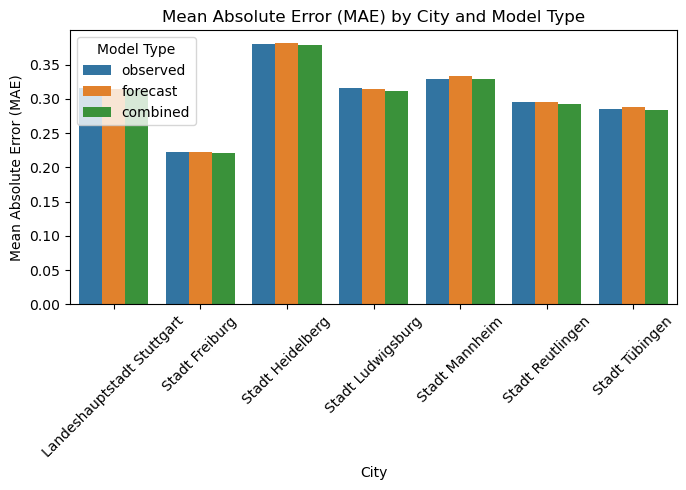

In [155]:
# MAEs plotten
plt.figure(figsize=(7, 5))
sns.barplot(data=mae_results, x='city', y='MAE', hue='model_type')
plt.title('Mean Absolute Error (MAE) by City and Model Type')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('City')
plt.legend(title='Model Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Values very similar between the models --> it makes sense to take differences between MAEs instead of absolute values

In [156]:
# Compute differences between the MAEs and store them in a DataFrame
mae_diff_list = []

for city in mae_results['city'].unique():
    mae_observed = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'observed')]['MAE'].values[0]
    mae_forecast = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'forecast')]['MAE'].values[0]
    mae_combined = mae_results[(mae_results['city'] == city) & (mae_results['model_type'] == 'combined')]['MAE'].values[0]

    diff_observed_forecast = mae_forecast - mae_observed
    diff_observed_combined = mae_combined - mae_observed
    diff_forecast_combined = mae_combined - mae_forecast

    # Extend list instead of concat
    mae_diff_list.extend([
        {'city': city, 'model_comparison': 'forecast - observed', 'MAE_difference': diff_observed_forecast},
        {'city': city, 'model_comparison': 'combined - observed', 'MAE_difference': diff_observed_combined},
        {'city': city, 'model_comparison': 'combined - forecast', 'MAE_difference': diff_forecast_combined}
    ])

# Create DataFrame
mae_differences = pd.DataFrame(mae_diff_list)
del mae_diff_list
print(mae_differences)

                          city     model_comparison  MAE_difference
0   Landeshauptstadt Stuttgart  forecast - observed       -0.001307
1   Landeshauptstadt Stuttgart  combined - observed       -0.004004
2   Landeshauptstadt Stuttgart  combined - forecast       -0.002697
3               Stadt Freiburg  forecast - observed        0.000148
4               Stadt Freiburg  combined - observed       -0.001323
5               Stadt Freiburg  combined - forecast       -0.001471
6             Stadt Heidelberg  forecast - observed        0.000246
7             Stadt Heidelberg  combined - observed       -0.002780
8             Stadt Heidelberg  combined - forecast       -0.003027
9            Stadt Ludwigsburg  forecast - observed       -0.001216
10           Stadt Ludwigsburg  combined - observed       -0.004736
11           Stadt Ludwigsburg  combined - forecast       -0.003520
12              Stadt Mannheim  forecast - observed        0.003969
13              Stadt Mannheim  combined - obser

### MAE differences with CIs

In [157]:
def block_bootstrap_ci(y_true, y_hat_obs, y_hat_fc, y_hat_comb, block_size=168, n_bootstrap=2000, confidence=0.95):
    """
    Block Bootstrap für Zeitreihen mit replacement
    block_size: 168 = 1 Woche (Stunden)
    Returns: MAE difference on the original test set, CI_lower, CI_upper per city per model comparison
    3 comparisons: forecast - observed, observed - combined, forecast - combined
    """
    n = len(y_true)
    n_blocks = int(np.ceil(n / block_size))
    
    bootstrap_diffs_fc_obs = []
    bootstrap_diffs_obs_comb = []
    bootstrap_diffs_fc_comb = []
    
    np.random.seed(42)
    
    for _ in range(n_bootstrap):
        # select random blocks with replacement
        block_indices = np.random.choice(n_blocks, size=n_blocks, replace=True)
        
        # combine indices
        sampled_indices = []
        for block_idx in block_indices:
            start = block_idx * block_size
            end = min(start + block_size, n)
            sampled_indices.extend(range(start, end))
        
        sampled_indices = sampled_indices[:n]
        
        # calculate 3 MAEs
        mae_obs = mean_absolute_error(y_true[sampled_indices], y_hat_obs[sampled_indices])
        mae_fc = mean_absolute_error(y_true[sampled_indices], y_hat_fc[sampled_indices])
        mae_comb = mean_absolute_error(y_true[sampled_indices], y_hat_comb[sampled_indices])
        
        # calculate differences
        bootstrap_diffs_fc_obs.append(mae_fc - mae_obs)
        bootstrap_diffs_obs_comb.append(mae_obs - mae_comb)
        bootstrap_diffs_fc_comb.append(mae_fc - mae_comb)
    
    # convert to numpy arrays
    diffs_fc_obs = np.array(bootstrap_diffs_fc_obs)
    diffs_obs_comb = np.array(bootstrap_diffs_obs_comb)
    diffs_fc_comb = np.array(bootstrap_diffs_fc_comb)

    # calculate MAE differences on the original test set
    mae_obs_orig = mean_absolute_error(y_true, y_hat_obs)
    mae_fc_orig = mean_absolute_error(y_true, y_hat_fc)
    mae_comb_orig = mean_absolute_error(y_true, y_hat_comb)
    diff_fc_obs_orig = mae_fc_orig - mae_obs_orig
    diff_obs_comb_orig = mae_obs_orig - mae_comb_orig
    diff_fc_comb_orig = mae_fc_orig - mae_comb_orig
    
    # Confidence intervals
    alpha = (1 - confidence) / 2
    
    results = {
        'forecast - observed': {
            'MAE difference': diff_fc_obs_orig,
            'lower': np.percentile(diffs_fc_obs, alpha * 100),
            'upper': np.percentile(diffs_fc_obs, (1 - alpha) * 100),
        },
        'observed - combined': {
            'MAE difference': diff_obs_comb_orig,
            'lower': np.percentile(diffs_obs_comb, alpha * 100),
            'upper': np.percentile(diffs_obs_comb, (1 - alpha) * 100),
        },
        'forecast - combined': {
            'MAE difference': diff_fc_comb_orig,
            'lower': np.percentile(diffs_fc_comb, alpha * 100),
            'upper': np.percentile(diffs_fc_comb, (1 - alpha) * 100),
        }
    }
    
    return results

In [158]:
# Bootstrap CIs for every city and every model comparison
bootstrap_results = []

for city in dfs_ys.keys():
    df_city = dfs_ys[city]
    
    y_true = df_city['y_test'].values
    y_hat_obs = df_city['y_test_hat weather'].values
    y_hat_fc = df_city['y_test_hat forecast'].values
    y_hat_comb = df_city['y_test_hat both'].values
    
    # Calculate Bootstrap CIs
    results = block_bootstrap_ci(y_true, y_hat_obs, y_hat_fc, y_hat_comb)
    print("completed city:", city)
    
    # Store results in list
    for comparison, values in results.items():
        bootstrap_results.append({
            'city': city,
            'model_comparison': comparison,
            'MAE_difference': values['MAE difference'],
            'CI_lower': values['lower'],
            'CI_upper': values['upper'],
        })

bootstrap_df = pd.DataFrame(bootstrap_results)
print(bootstrap_df)

completed city: Landeshauptstadt Stuttgart
completed city: Stadt Freiburg
completed city: Stadt Heidelberg
completed city: Stadt Ludwigsburg
completed city: Stadt Mannheim
completed city: Stadt Reutlingen
completed city: Stadt Tübingen
                          city     model_comparison  MAE_difference  CI_lower  \
0   Landeshauptstadt Stuttgart  forecast - observed       -0.001307 -0.002273   
1   Landeshauptstadt Stuttgart  observed - combined        0.004004  0.003051   
2   Landeshauptstadt Stuttgart  forecast - combined        0.002697  0.001898   
3               Stadt Freiburg  forecast - observed        0.000148 -0.002031   
4               Stadt Freiburg  observed - combined        0.001323 -0.000396   
5               Stadt Freiburg  forecast - combined        0.001471 -0.000107   
6             Stadt Heidelberg  forecast - observed        0.000246 -0.001029   
7             Stadt Heidelberg  observed - combined        0.002780  0.001720   
8             Stadt Heidelberg  for

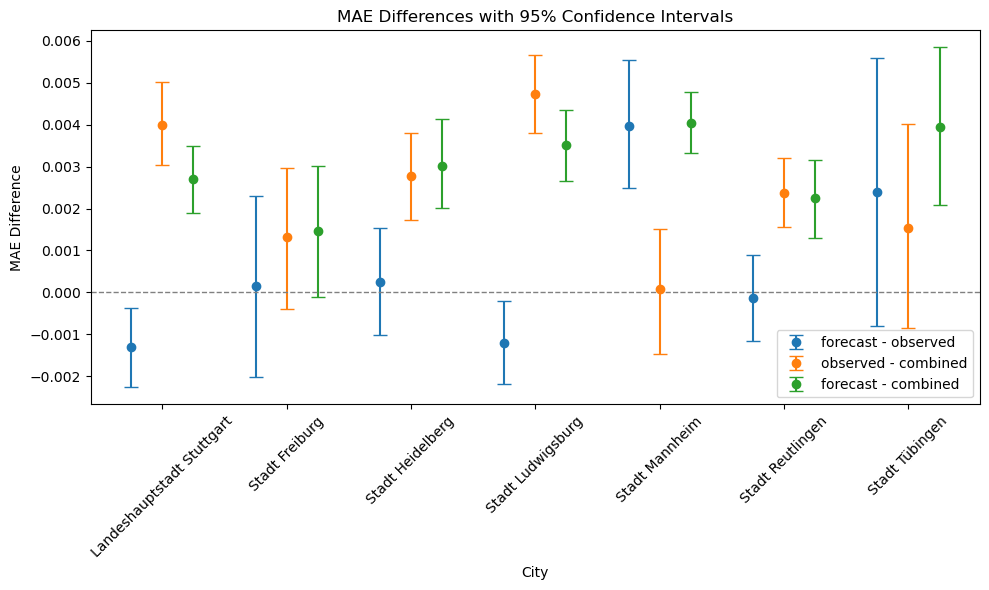

In [159]:
# visualization with confidence intervals
plt.figure(figsize=(10, 6))

for i, comparison in enumerate(['forecast - observed', 'observed - combined', 'forecast - combined']):
    data = bootstrap_df[bootstrap_df['model_comparison'] == comparison]
    x_positions = np.arange(len(data)) + i * 0.25
    
    plt.errorbar(x_positions, data['MAE_difference'], 
                 yerr=[data['MAE_difference'] - data['CI_lower'], 
                       data['CI_upper'] - data['MAE_difference']],
                 fmt='o', label=comparison, capsize=5)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(np.arange(len(data)) + 0.25, data['city'].unique(), rotation=45)
plt.ylabel('MAE Difference')
plt.xlabel('City')
plt.title('MAE Differences with 95% Confidence Intervals')
plt.legend()
plt.tight_layout()
plt.show()

Mean of MAE over all cities with bootstrap of the cities

In [160]:
comparisons = bootstrap_df['model_comparison'].unique()
results_list = []

np.random.seed(42)
n_bootstrap = 2000
confidence = 0.95

for comparison in comparisons:
    MAEs_per_model = bootstrap_df[bootstrap_df['model_comparison'] == comparison]
    cities = MAEs_per_model['city'].values
    n_cities = len(cities)
    
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        # sample cities with replacement
        sampled_cities = np.random.choice(cities, size=n_cities, replace=True)
        
        # MAE differences of the sampled cities
        sampled_diffs = np.array([MAEs_per_model[MAEs_per_model['city'] == city]['MAE_difference'].values[0] for city in sampled_cities])
        
        # calculate mean
        bootstrap_means.append(np.mean(sampled_diffs))
    
    bootstrap_means = np.array(bootstrap_means)
    
    # Original mean
    mean_diff_orig = MAEs_per_model['MAE_difference'].mean()
    
    # Confidence intervals
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, alpha * 100)
    ci_upper = np.percentile(bootstrap_means, (1 - alpha) * 100)
    
    results_list.append({
        'model_comparison': comparison,
        'mean_MAE_difference': mean_diff_orig,
        'CI_lower': ci_lower,
        'CI_upper': ci_upper,
    })

mean_differences_df = pd.DataFrame(results_list)
del results_list, bootstrap_means
print(mean_differences_df)

      model_comparison  mean_MAE_difference  CI_lower  CI_upper
0  forecast - observed             0.000588 -0.000570  0.001927
1  observed - combined             0.002405  0.001323  0.003479
2  forecast - combined             0.002992  0.002366  0.003644


In [161]:
# save data needed for forest plot
mean_differences_df.to_csv('../data/mean_mae_differences_forest_plot.csv', index=False)
bootstrap_df.to_csv('../data/mae_differences_per_city.csv', index=False)